# 02_Bidirect LSTM
 - 구글 collab으로 실행하였습니다

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import pandas as pd
import numpy as np
import re
import json

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold, train_test_split

## 1. 데이터불러오기

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
feature = pd.read_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/02_Deep_Learning/data/feature.csv', index_col=[0])
target = pd.read_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/02_Deep_Learning/data/target.csv', index_col=[0])

word_index_json = open('/content/drive/MyDrive/악성댓글_필터링_봇_모델/02_Deep_Learning/data/word_index_vocab.json', 'r').read()
word_index_vocab = json.loads(word_index_json)

## 2. 데이터토큰화 & 패딩

#### 텍스트 음절단위로 자르기

In [5]:
feature_split = feature['댓글'].apply(list).tolist()

#### 정수인덱싱

In [6]:
tokenizer = Tokenizer()
tokenizer.word_index = word_index_vocab

feature_sequences = tokenizer.texts_to_sequences(feature_split)

### 패딩

In [7]:
feature_input = pad_sequences(feature_sequences, padding='post', maxlen=400)

## 3. SMOTE를 이용한 라벨 불균형 해소

In [23]:
# target.value_counts()

 - 라벨 0은 446162, 1은 2897, 2는 4993으로 균형이 잡혀있지않아 recall(재현율)이 떨어질 가능성이 높다
 - 그래서 SMOTE를 이용하여 라벨이 1과 2인 경우를 복제하여 라벨학습의 균형을 맞추어 주는 것이다
 - 이것을 `오버샘플링`이라 한다.

In [24]:
# from imblearn.over_sampling import SMOTE

In [25]:
# smote = SMOTE(random_state=123)
# feature_over, target_over = smote.fit_sample(feature_input, target)

In [26]:
# pd.Series(target_over).value_counts()

In [8]:
feature_over = np.array(feature_input)
target_over = np.array(target)

## 4. Bidirect LSTM + K-Fold 구현

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score

In [10]:
vocab_size = len(word_index_vocab)
embedding_dim = 128
max_length = 400
n_class = 2

In [11]:
def get_model():
  from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
  from tensorflow.keras.models import Sequential, load_model
  
  model = Sequential()
  model.add(Embedding(vocab_size+1, embedding_dim, input_length=max_length))
  model.add(Bidirectional(LSTM(64, return_sequences=True)))
  model.add(Bidirectional(LSTM(64, return_sequences=False)))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

  return model

In [12]:
# 3-Fold 시행
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=3, random_state=123, shuffle=True)

In [13]:
validation_pred = np.zeros((feature_over.shape[0], 1))


k = 0
for train_idx, val_idx in tqdm_notebook(cv.split(feature_over, target_over)) :

    print('{}번째 Fold 시작' .format(k+1))

    x_train = feature_over[train_idx]
    y_train = target_over[train_idx]

    x_validation = feature_over[val_idx]
    y_validation = target_over[val_idx]

    LSTM = get_model()
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

    LSTM.fit(x_train, y_train,
             callbacks          = [es],
             epochs             = 20,
             batch_size         = 64,
             validation_data    = (x_validation, y_validation))
    
    validation_pred[val_idx, : ] = LSTM.predict(x_validation) 
    print('')

    k += 1

1번째 Fold 시작
Epoch 1/20
1197/1197 [==============================] - 113s 86ms/step - loss: 0.4629 - accuracy: 0.7808 - val_loss: 0.2790 - val_accuracy: 0.8889
Epoch 2/20
1197/1197 [==============================] - 101s 84ms/step - loss: 0.2554 - accuracy: 0.9011 - val_loss: 0.2515 - val_accuracy: 0.9063
Epoch 3/20
1197/1197 [==============================] - 101s 84ms/step - loss: 0.2263 - accuracy: 0.9141 - val_loss: 0.2432 - val_accuracy: 0.9078
Epoch 4/20
1197/1197 [==============================] - 100s 83ms/step - loss: 0.2115 - accuracy: 0.9199 - val_loss: 0.2301 - val_accuracy: 0.9147
Epoch 5/20
1197/1197 [==============================] - 100s 83ms/step - loss: 0.2077 - accuracy: 0.9215 - val_loss: 0.2401 - val_accuracy: 0.9078
Epoch 6/20
1197/1197 [==============================] - 99s 83ms/step - loss: 0.2093 - accuracy: 0.9198 - val_loss: 0.2350 - val_accuracy: 0.9116
Epoch 00006: early stopping

2번째 Fold 시작
Epoch 1/20
1197/1197 [==============================] - 105s 84ms/

## 5. 모델 평가

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, make_scorer
import matplotlib.pyplot as plt

In [15]:
y_prob = validation_pred
y_test = target_over

AUC는? : 0.9582951


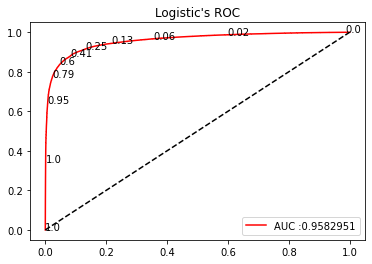

In [16]:
# Threshold변화에 따른 fpr, tpr의 변화
fpr_array, tpr_array, threshold_array = roc_curve(y_test, y_prob)

# 그래프에 threshold를 표시하기위해 인덱스 추출
idx_list = np.arange(1, len(threshold_array), 2000)


# ROC 그래프 그리기
plt.plot(fpr_array, tpr_array, 
         c = 'red', 
         label = "AUC :" + str(round(roc_auc_score(y_test, y_prob), 7)))
plt.plot([0, 1], [0,1], ls='--', c='black')
plt.title("Logistic's ROC")
plt.legend(loc=0)
for idx in idx_list:
    text = str(round(threshold_array[idx], 2))
    plt.text(fpr_array[idx], tpr_array[idx], text)


# ROC의 auc는?
print('AUC는? :', round(roc_auc_score(y_test, y_prob), 7))